In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torchaudio
import torch
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

모델링

In [ ]:
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [ ]:
import torchvision.transforms as transforms
# batch must contain tensors, numpy arrays, numbers, dicts or lists
compose = transforms.Compose([
    transforms.CenterCrop((200,330)),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
data_dir = '/content/drive/MyDrive/dataset_doeun_0825/spec/'
dataset = torchvision.datasets.ImageFolder(data_dir,transform=compose)

In [ ]:
len(dataset)

1090

In [ ]:
from torch.utils.data import random_split
seed_everything(42)
train_data, test_data = random_split(dataset,[800,290])
#train_data, test_data, TEST = random_split(dataset,[603,240,200])

In [ ]:
print('train sets: {}'.format(len(train_data)))
print('test sets: {}'.format(len(test_data)))

train sets: 800
test sets: 290


In [ ]:
len_train_data = len(train_data)
len_test_data = len(test_data)

In [ ]:
BATCH_SIZE = 10

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

### Resnet

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [ ]:
from torchvision.models import resnet50#, ResNet50_Weights

model = resnet50(pretrained = False)
#for param in model.parameters():
#    param.requires_grad = False

model.l1 = nn.Linear(2048, 2)# 마지막 클래스의 갯수로 학습
nn.init.kaiming_normal_(model.l1.weight)

model.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         nn.Dropout(0.3),
                         model.l1)

model = model.to(device)

In [ ]:
n = 0
for data, target in train_loader:
    print(data.shape) # (batch, channel, width, height)
    break

data = data.to(device)

with torch.no_grad():
    y = model(data)
    print(y)
    print(np.argmax(y.cpu(), axis=1), target)

torch.Size([10, 3, 200, 250])
tensor([[ 0.1919,  0.8665],
        [-0.4414, -0.6707],
        [ 0.8236,  0.7970],
        [-0.3390,  1.0711],
        [-0.3626,  0.9285],
        [-2.2713, -2.6760],
        [-1.2032, -1.4164],
        [ 1.0106,  2.5105],
        [ 0.6325,  0.7091],
        [-0.1568, -0.8926]], device='cuda:0')
tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 0]) tensor([0, 1, 0, 0, 0, 0, 0, 0, 1, 0])


0이 기침

precision: true 예측 중 실제 true
recall: 실제 true 중 true 예측


In [ ]:
seed_everything(42)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 60

list_training_loss = []
list_test_loss = []
batch_length = int(len_train_data / BATCH_SIZE)

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0
    model.train()
    for train_data, train_target in train_loader:
        train_data = train_data.to(device)
        train_target = train_target.to(device)
        y = model(train_data)
        del train_data
        loss = criterion(y, train_target).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += 1
        del train_target

    if (epoch % 4 == 0) | (epoch == n_epochs):
      model.eval()
      n_test = 0
      test_loss = 0
      correct, total = 0, 0
      num_non, pred_non, TP = 0, 0, 0
      for test_data, test_target in test_loader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = correct * 100 / total
      recall = TP * 100 / (total - num_non)
      precision = TP * 100 / (total - pred_non)
      f1score = 2 *(precision*recall) / (precision + recall)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + 1, train_loss / n_train, test_loss / n_test, accuracy, precision, recall, f1score))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

epoch 1th training loss: 0.8640307287336327 test loss: 0.4939799825179166, accuracy: 79.31034088134766, precision: 76.08695983886719, recall: 79.54545593261719, f1 score: 77.77777862548828
epoch 5th training loss: 0.49632595307193694 test loss: 0.3882594519648059, accuracy: 83.10344696044922, precision: 76.10063171386719, recall: 91.66666412353516, f1 score: 83.16150665283203
epoch 9th training loss: 0.38700625160709023 test loss: 1.859249973091586, accuracy: 67.5862045288086, precision: 59.22330093383789, recall: 92.42424011230469, f1 score: 72.18934631347656
epoch 13th training loss: 0.3792806120123714 test loss: 0.5510352922539259, accuracy: 82.75862121582031, precision: 77.70270538330078, recall: 87.1212158203125, f1 score: 82.14286804199219
epoch 17th training loss: 0.49241004628129303 test loss: 0.3232955147737059, accuracy: 86.55172729492188, precision: 86.61417388916016, recall: 83.33333587646484, f1 score: 84.94208526611328
epoch 21th training loss: 0.3356028727022931 test los

In [ ]:
accuracy

tensor(80.3448, device='cuda:0')

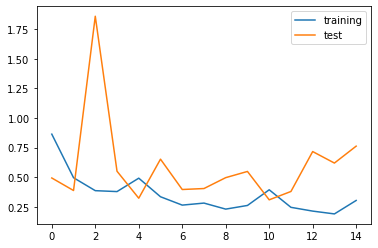

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 60

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0
    model.train()
    for train_data, train_target in train_loader:
        train_data = train_data.to(device)
        train_target = train_target.to(device)
        y = model(train_data)
        del train_data
        loss = criterion(y, train_target).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += 1
        del train_target

    if epoch % 4 == 0:
      model.eval()
      n_test = 0
      test_loss = 0
      correct, total = 0, 0
      num_non, pred_non, TP = 0, 0, 0
      for test_data, test_target in test_loader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = correct * 100 / total
      recall = TP * 100 / (total - num_non)
      precision = TP * 100 / (total - pred_non)
      f1score = 2 *(precision*recall) / (precision + recall)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + 61, train_loss / n_train, test_loss / n_test, accuracy, precision, recall, f1score))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

epoch 61th training loss: 0.4525320800254121 test loss: 0.3414368724514698, accuracy: 85.51724243164062, precision: 80.40540313720703, recall: 90.1515121459961, f1 score: 84.99999237060547
epoch 65th training loss: 0.3874189745518379 test loss: 3.3126736632708846, accuracy: 73.44827270507812, precision: 63.68159103393555, recall: 96.96969604492188, f1 score: 76.87687683105469
epoch 69th training loss: 0.2786944992898498 test loss: 0.4054866765529431, accuracy: 87.24137878417969, precision: 82.31292724609375, recall: 91.66666412353516, f1 score: 86.73835754394531
epoch 73th training loss: 0.27578306785435414 test loss: 0.5298939117326819, accuracy: 82.75862121582031, precision: 78.08219146728516, recall: 86.36363983154297, f1 score: 82.01438903808594
epoch 77th training loss: 0.2360459104878828 test loss: 0.39971430034473027, accuracy: 82.75862121582031, precision: 84.74576568603516, recall: 75.75757598876953, f1 score: 80.0
epoch 81th training loss: 0.25591657443437726 test loss: 1.026

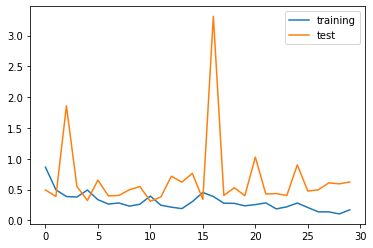

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

새로 나누기 (2)

In [ ]:
from torch.utils.data import random_split
seed_everything(1004)
train_data, test_data = random_split(dataset,[750,340])

BATCH_SIZE = 10
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
num=0
for _, test_target in test_loader:
  num += test_target
print(num.sum())

tensor(166)


In [ ]:
seed_everything(1004)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 60

batch_length = int(len_train_data / BATCH_SIZE)

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0
    model.train()
    for train_data, train_target in train_loader:
        train_data = train_data.to(device)
        train_target = train_target.to(device)
        y = model(train_data)
        del train_data
        loss = criterion(y, train_target).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += 1
        del train_target

    if epoch % 4 == 0:
      model.eval()
      n_test = 0
      test_loss = 0
      correct, total = 0, 0
      num_non, pred_non, TP = 0, 0, 0
      for test_data, test_target in test_loader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = correct * 100 / total
      recall = TP * 100 / (total - num_non)
      precision = TP * 100 / (total - pred_non)
      f1score = 2 *(precision*recall) / (precision + recall)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + 51, train_loss / n_train, test_loss / n_test, round(accuracy,6), round(precision,6), round(recall,6), round(f1score,6)))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

epoch 51th training loss: 0.26132002151881656 test loss: 0.19534408531206496, accuracy: 92.94117736816406, precision: 89.89361572265625, recall: 97.12643432617188, f1 score: 93.37015533447266
epoch 55th training loss: 0.1310822335196038 test loss: 0.21541767194524736, accuracy: 91.76470947265625, precision: 88.82978820800781, recall: 95.97701263427734, f1 score: 92.26520538330078
epoch 59th training loss: 0.15124736239202322 test loss: 0.23675299717989914, accuracy: 92.05882263183594, precision: 92.48554992675781, recall: 91.95402526855469, f1 score: 92.21902465820312
epoch 63th training loss: 0.18352233561997613 test loss: 0.3813874574706835, accuracy: 90.88235473632812, precision: 89.50276184082031, recall: 93.10344696044922, f1 score: 91.26760864257812
epoch 67th training loss: 0.13589812372190258 test loss: 0.2789683399365886, accuracy: 91.17647552490234, precision: 92.35294342041016, recall: 90.2298812866211, f1 score: 91.27906799316406
epoch 71th training loss: 0.1172487333021126

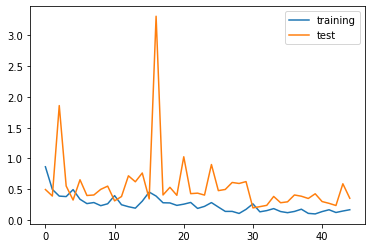

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()

새로 나누기 (3)

In [ ]:
from torch.utils.data import random_split
seed_everything(2)
train_data, test_data = random_split(dataset,[800,290])

BATCH_SIZE = 10

train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [ ]:
num=0
for _, test_target in test_loader:
  num += test_target
print(num.sum())

tensor(144)


In [ ]:
seed_everything(2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 45

batch_length = int(len_train_data / BATCH_SIZE)

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0
    model.train()
    for train_data, train_target in train_loader:
        train_data = train_data.to(device)
        train_target = train_target.to(device)
        y = model(train_data)
        del train_data
        loss = criterion(y, train_target).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += 1
        del train_target

    if epoch % 4 == 0:
      model.eval()
      n_test = 0
      test_loss = 0
      correct = 0
      total = 0
      num_non, pred_non = 0, 0
      TP=0
      for test_data, test_target in test_loader:
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        y_pred = model(test_data)
        idx_pred = torch.max(y_pred, 1)[1]
        del test_data
        loss = criterion(y_pred, test_target).sum()
        test_loss += loss.data.cpu().numpy()
        n_test += 1
        total += len(test_target)
        num_non += test_target.sum()
        pred_non += idx_pred.sum()
        correct += (idx_pred == test_target).sum()
        TP += (idx_pred == test_target).sum() - (idx_pred * test_target == 1).sum()

      accuracy = correct * 100 / total
      recall = TP * 100 / (total - num_non)
      precision = TP * 100 / (total - pred_non)
      f1score = 2 *(precision*recall) / (precision + recall)
      print('epoch {}th training loss: {} test loss: {}, accuracy: {}, precision: {}, recall: {}, f1 score: {}'.format(
            epoch + 101, train_loss / n_train, test_loss / n_test, round(accuracy,6), round(precision,6), round(recall,6), round(f1score,6)))
      list_training_loss.append(train_loss / n_train)
      list_test_loss.append(test_loss / n_test)

epoch 101th training loss: 0.12647136713057988 test loss: 0.18593006300868403, accuracy: 92.75862121582031, precision: 96.99247741699219, recall: 88.35616302490234, f1 score: 92.47311401367188
epoch 105th training loss: 0.13517032034287696 test loss: 0.16814025425641188, accuracy: 92.4137954711914, precision: 94.28571319580078, recall: 90.41095733642578, f1 score: 92.30769348144531
epoch 109th training loss: 0.13905134710985295 test loss: 0.23795058912244335, accuracy: 90.0, precision: 92.08633422851562, recall: 87.67123413085938, f1 score: 89.8245620727539
epoch 113th training loss: 0.07245791471459598 test loss: 0.1815512982148934, accuracy: 91.37931060791016, precision: 92.30769348144531, recall: 90.41095733642578, f1 score: 91.34947967529297
epoch 117th training loss: 0.14999526560059168 test loss: 0.20927608958325059, accuracy: 90.68965148925781, precision: 93.43065643310547, recall: 87.67123413085938, f1 score: 90.45936584472656
epoch 121th training loss: 0.12008426555112237 test

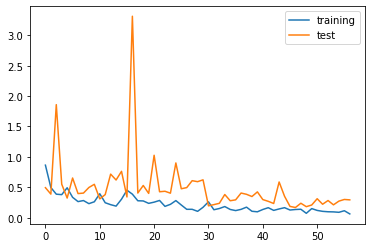

tensor(91.7241, device='cuda:0') : 225번


In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()
print(accuracy, ': 225번')

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
cd /content/drive/MyDrive/project_cough

/content/drive/MyDrive/project_cough


In [ ]:
torch.save({
            'epoch': 225,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': list_training_loss[-1],
            'test_loss': list_test_loss[-1]
        },
        'model225.pt') 